## Intel sensors level A2

Authors: Martin Kostelník, Marianne Jakonen, Ahmed

---

Daily and weekly seasonality analysis

In [136]:
# Imports
import helper
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Define some paths
DATA_PATH = r"../data/data.txt.gz"
DATA_PROCESSED_PATH = r"../data/data_processed.csv"

Preprocessing (cleaning, resampling, interpolation) data takes some time, so I did it once and saved into into new file.

In [137]:
# First let's get the data
# I preprocessed the data and saved it for faster loading

# Load raw data
# data_raw = helper.load_data(DATA_PATH)

# Preprocess data
# data = helper.preprocess_data(data_raw)
# data.to_csv("data_resampled.csv")

Now we have the preprocessed data ready, let's load it. We have to convert datetime to correct data type again.

In [138]:
# Load processed data
df = pd.read_csv(DATA_PROCESSED_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])

Let's find the most correlated variable.

In [139]:
# Find the most correlated variable
correlation = df.corr(numeric_only=True).abs().sum().sort_values(ascending=False)
correlation

H-26    92.736138
H-30    92.091317
H-31    91.160904
H-27    90.419350
H-29    89.718965
          ...    
T-38    44.422759
L-46    43.764384
H-53    39.741264
T-35    36.455761
T-6     32.416700
Length: 156, dtype: float64

We can see that the most correlated variable is humidity of a sensor number 26.
Let's take it out of a dataframe as it is the variable we will make predictions for.

Now for the daily seasonality. I selected a week starting from 01.03.2004, which is monday. I also decided to test for 10 components maximum. With the default resampling frequency of 2 hours, each day has 12 measurements. I chose the training/testing ratio of 8/4;

In [140]:
MAX_COMPS = 10
TEST_LEN = 4

r2s = np.zeros((7, MAX_COMPS))
q2s = np.zeros((7, MAX_COMPS))

for n_comps in range(1, MAX_COMPS + 1):
    for day in range(1, 8):
        # Select day data
        X = df[df["datetime"].dt.date == pd.to_datetime(f"2004-03-0{day}")].loc[:, df.columns != "H-26"].drop(columns=["datetime"])
        Y = df[df["datetime"].dt.date == pd.to_datetime(f"2004-03-0{day}")]["H-26"]

        # Divide into train and test
        X_train = X.iloc[:-TEST_LEN, :]
        X_test = X.iloc[-TEST_LEN:]
        Y_train = Y.iloc[:-TEST_LEN]
        Y_test = Y.iloc[-TEST_LEN:]

        # Scale
        X_train_mean = X_train.mean()
        X_train_std = X_train.std()
        Y_train_mean = Y_train.mean()
        Y_train_std = Y_train.std()

        X_train = (X_train - X_train_mean) / X_train_std
        X_test = (X_test - X_train_mean) / X_train_std
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_std

        # Predict
        pls = PLSRegression(n_components = n_comps)
        pls.fit(X_train, Y_train)
        Y_pred = pls.predict(X_test)

        # Let's transform it to np.arrays for easier math
        Y_pred = np.array(Y_pred).squeeze()
        Y_test = np.array(Y_test)

        # R2
        r2 = r2_score(Y_test, Y_pred)
        r2s[day-1, n_comps-1] = r2

        # Q2
        TSSRes = np.sum((Y_train - Y_train.mean()) ** 2)
        PRESS = np.sum((Y_test - Y_pred) ** 2)
        q2s [day-1, n_comps-1] = 1 - PRESS / TSSRes 

Now let's plot heatmaps of Q2 and R2 values. Lets's first transform the np.arrays to dataframes with custom colums and indices.

In [141]:
cols = [str(i) for i in range(1, MAX_COMPS + 1)]
idx = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_q2 = pd.DataFrame(q2s, columns=cols, index=idx)
df_r2 = pd.DataFrame(r2s, columns=cols, index=idx)

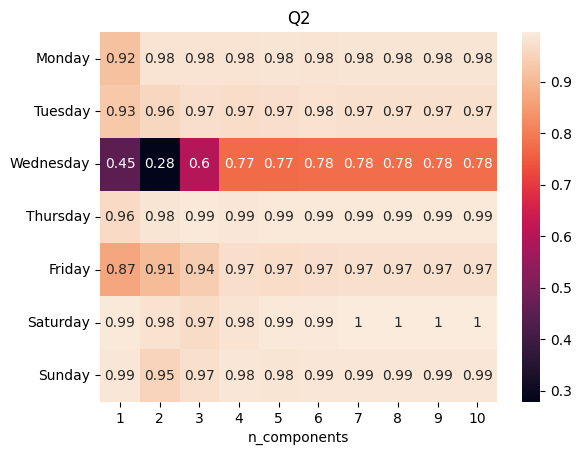

In [142]:
ax = sns.heatmap(df_q2, annot=True)
ax.set(title="Q2", xlabel="n_components")
plt.show()

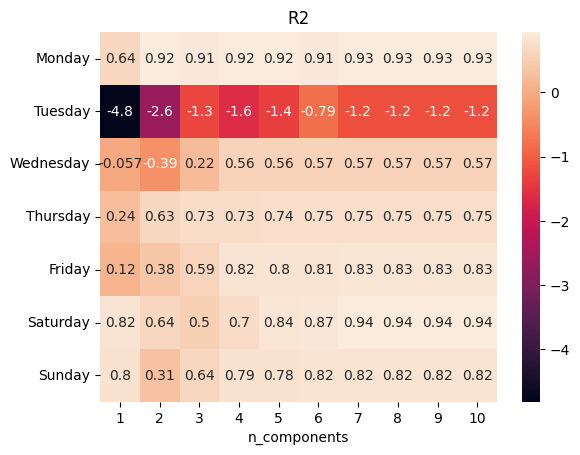

In [143]:
ax = sns.heatmap(df_r2, annot=True)
ax.set(title="R2", xlabel="n_components")
plt.show()